# Overfitting and Underfitting

When we compare the training and validation errors, we want to watch out the gap between them. If the model is unable to reduce training errors, it is too insufficiently expressive to capture the pattern of data. When training error is significantly lower than validation error, we might be seeing overfitting.

Model complexity and the gap between training/validation error could be illustrated by following graph

![capacity_vs_error](http://www.d2l.ai/_images/capacity_vs_error.svg)

**Data Set Size** also makes significant impact to overfitting/underfitting. The fewer samples we have in the training dataset, the more likely we are to encounter overfitting. However, the more data we have, the more tendency for us to use sophisticated model to fit the data, making final model overcomplex.

Absent sufficient data, simpler models may be difficult to beat.

The current success of deep learning owes to the abundance of massive datasets, advances in computing power, price competitiveness in data storage, and advances in distributed computing.

# Polynomial Regression

We could illustrate above tradeoff between model complexity and precision by trying to fit a data generated by a polynomial

$$ y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6\frac{x^3}{3!} + \epsilon \text{ where } \epsilon \sim \mathcal{N}(0,0.1) $$

The noise term $\epsilon$ follows a normal distribution with a mean of 0 and standard deviation of 0.1. We will synthesize 100 samples eac for the training set and the validation set.

In [1]:
import mxnet as mx
from mxnet import nd, gluon, autograd
from mxnet.gluon import nn
import d2l

In [2]:
maxdegree = 20
n_train, n_test = 100, 100
true_w = nd.zeros(maxdegree)
true_w[0:4] = nd.array([5, 1.2, -3.4, 5.6])

## Randomize X
features = nd.random.normal(shape=(n_train + n_test,1))
features = nd.random.shuffle(features)

## Randomize the data using polynomial coefficients
poly_features = nd.power(features, nd.arange(maxdegree).reshape((1,-1)))
poly_features = poly_features / (nd.gamma(nd.arange(maxdegree) + 1).reshape((1,-1)))

## Calculate the true labels and calibrate them using a small random noise
labels = nd.dot(poly_features, true_w)
labels += nd.random.normal(scale=0.1, shape=labels.shape)

**poly_features** are rescaled from $x^i$ to $\frac{1}{i!}x^i$ to avoid very large exponents $i$. Factorials are implemented by the Gamma function 

$$ n! = \Gamma(n + 1) $$

Because mxnet automatically infers the number of inputs by looking at dimensions of input data, we need to generate data with **maxdegree** of features. The data should have dimension of (200, 20) as it has 200 data (100 for traininng purpose, 100 for validation purpose) and 20 features.

Also because we use polynomial of degree 4 to generate data, we should expect data from feature 5 to 20 to have a small value that is closed to zero (due to noise)

In [3]:
poly_features.shape, labels.shape

((200, 20), (200,))

In [4]:
poly_features[0:3]


[[1.0000000e+00 1.5094751e+00 1.1392574e+00 5.7322693e-01 2.1631797e-01
  6.5305315e-02 1.6429458e-02 3.5428370e-03 6.6847802e-04 1.1211676e-04
  1.6923748e-05 2.3223611e-06 2.9212887e-07 3.3920092e-08 3.6572534e-09
  3.6803552e-10 3.4721281e-11 3.0829944e-12 2.5853909e-13 2.0539909e-14]
 [1.0000000e+00 1.9676613e+00 1.9358451e+00 1.2696959e+00 6.2458295e-01
  2.4579351e-01 8.0606394e-02 2.2658013e-02 5.5729118e-03 1.2184002e-03
  2.3973989e-04 4.2884261e-05 7.0318088e-06 1.0643244e-06 1.4958786e-07
  1.9622549e-08 2.4131583e-09 2.7931044e-10 3.0532687e-11 3.1619989e-12]
 [1.0000000e+00 5.6045949e-01 1.5705740e-01 2.9341439e-02 4.1111722e-03
  4.6082909e-04 4.3046010e-05 3.4465063e-06 2.4145339e-07 1.5036093e-08
  8.4271218e-10 4.2936911e-11 2.0053666e-12 8.6455901e-14 3.4610738e-15
  1.2931944e-16 4.5298950e-18 1.4934248e-19 4.6500233e-21 1.3716576e-22]]
<NDArray 3x20 @cpu(0)>

## How we evaluate the loss

We are going to train the same training data several times (epoch). Each time of training, we will try to evaluate the loss as the everage loss after going through the whole training dataset.

We are going to go through the whole dataset, calculate the loss, and divide the whole loss by the number of data points.

In [5]:
def evaluate_loss(net, data_iter, loss):
    """Evaluate the average loss of a model given dataset
    Input: 
    - net: the neural network
    - data_iter: the iterator to the dataset
    - loss: the loss function
    """
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        metric.add(loss(net(X), y).sum().asscalar(), y.size)
    return metric[0] / metric[1]

def load_array(data_arrays, batch_size, is_train=True):
    """Construct a Gluon data loader"""
    dataset = gluon.data.ArrayDataset(*data_arrays)
    return gluon.data.DataLoader(dataset, batch_size, shuffle=is_train)

## Data Training

For each epoch, we use the Stochastic Gradient Decent to update our parameters to its gradient and hopefully wait for them to get to the minima.

In [6]:
def train_epoch(net, train_iter, loss, updater):
    for X, y in train_iter:
        with autograd.record():
            l = loss(net(X), y)
        l.backward()
        updater.step(X.shape[0])

def train(train_features, test_features, train_labels, 
          test_labels, num_epochs=1000):
    loss = gluon.loss.L2Loss()
    net = nn.Sequential()
    net.add(nn.Dense(1, use_bias=False))
    net.initialize()
    batch_size = min(10, train_labels.size)
    train_iter = load_array((train_features, train_labels), batch_size)
    test_iter = load_array((test_features, test_labels), batch_size, is_train=False)
    trainer = gluon.Trainer(net.collect_params(), 'sgd', 
                            {'learning_rate': 0.01})
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log', 
                           xlim=[1,num_epochs], ylim=[1e-3,1e2], legend=['train','test'])
    for epoch in range(1, num_epochs + 1):
        train_epoch(net, train_iter, loss, trainer)
        if epoch % 50 == 0:
            animator.add(epoch, (evaluate_loss(net, train_iter, loss),
                                 evaluate_loss(net, test_iter, loss)))
    print('weight', net[0].weight.data().asnumpy())

## Evaluation of fitting

### Normal Fitting
Because we already know that our data points are generated by the a polynomial of degree 4, with parameters are [5, 1.2, -3.4, 5.6]

Because a polynomial of degree 4 is the model used to generate the data, we should expect the training data and test data decrease over time and start to approach each other.

weight [[ 5.0161834  1.1761256 -3.4185135  5.642311 ]]


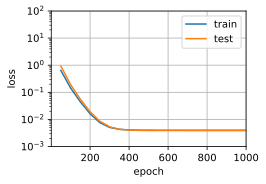

In [7]:
train(poly_features[:n_train, 0:4], poly_features[n_train:, 0:4], 
      labels[:n_train], labels[n_train:])

### Under Fitting

Under fitting occurs when our model is not sophisticated enough to express data. We should expect both the loss slightly high and not decrease over time.

weight [[ 4.891615  4.106179 -2.367709]]


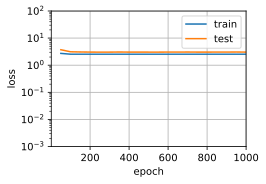

In [8]:
train(poly_features[:n_train, 0:3], poly_features[n_train:, 0:3], 
      labels[:n_train], labels[n_train:])

## Insufficent training (Overfitting)

With an overcomplex model, we fit data so well that the training error will be small, even smaller than our normal model. But we should observer a small gap between training and test data.

weight [[ 4.984162    1.303306   -3.2607439   5.036724   -0.38052025  1.610532
   0.04253034  0.22772393 -0.03228515  0.0335767  -0.01794511  0.01420899
   0.0074071   0.01047202 -0.06528641  0.02145072  0.06565462  0.02129446
  -0.02506039 -0.00960142]]


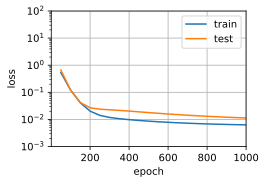

In [9]:
train(poly_features[:n_train, 0:20], poly_features[n_train:, 0:20], 
      labels[:n_train], labels[n_train:])

## Training Errors vs model complexity

From above graph, we notice that a polynomial with degree of 4 approximates data the best. Plotting the training error again the complexity of test data, we expect to see a graph likely similar to the graph at the beginning of this notebook

In [10]:
def plot_error_model_complexity(train_data, test_data, train_labels, test_labels, 
                                num_epochs=1000):
    loss = gluon.loss.L2Loss()
    batch_size = 10
    animator = d2l.Animator(xlabel='Degree', ylabel='loss', yscale='log', 
                           xlim=[1,maxdegree], ylim=[1e-3,1e2], legend=['train','test'])
    
    for deg in range(1, maxdegree+1):
        net = nn.Sequential()
        net.add(nn.Dense(1, use_bias=False))
        net.initialize()
        trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})
        
        # Seperate training data / test data by model complexity
        train_iter = load_array((train_data[:,0:deg], train_labels), batch_size)
        test_iter = load_array((test_data[:,0:deg], test_labels), batch_size, is_train=False)
        # Train model num_epochs times
        for epoch in range(num_epochs):
            train_epoch(net, train_iter, loss, trainer)
        animator.add(deg, (evaluate_loss(net, train_iter, loss),
                             evaluate_loss(net, test_iter, loss)))

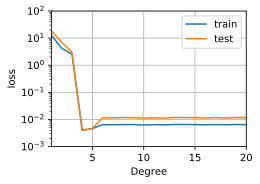

In [11]:
plot_error_model_complexity(poly_features[:n_train], poly_features[n_train:], 
                            labels[:n_train], labels[n_train:])

## Training error against the amount of data

The more training data we have, the more accurate the test should be.

In [12]:
train_data, train_labels = poly_features[:n_train], labels[:n_train]
test_data, test_labels = poly_features[n_train:], labels[n_train:]

def plot_error_amount_data(train_data, train_labels, test_data, test_labels, num_epochs=1000):
    loss = gluon.loss.L2Loss()
    batch_size = 10
    animator = d2l.Animator(xlabel='Data Size', ylabel='loss', yscale='log', 
                           xlim=[10,n_train], ylim=[1e-3,1e2], legend=['test'])
    
    for dsize in range(10, 110, 10):
        net = nn.Sequential()
        net.add(nn.Dense(1, use_bias=False))
        net.initialize()
        trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})
        
        # Seperate training data / test data by model complexity
        train_iter = load_array((train_data[:dsize, 0:4], train_labels[:dsize]), batch_size)
        test_iter = load_array((test_data[:dsize,0:4], test_labels[:dsize]), 
                               batch_size, is_train=False)
        # Train model num_epochs times
        for epoch in range(num_epochs):
            train_epoch(net, train_iter, loss, trainer)
        animator.add(dsize, evaluate_loss(net, test_iter, loss))

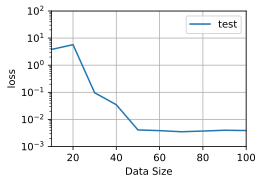

In [13]:
plot_error_amount_data(train_data, train_labels, test_data, test_labels)

# Regularization (Weight Decay)

In high polynomial degree model, we don't want our model to emphasize the importance of each specific feature. We want our model balance the importance of each feature, no matter how large the feature's degree is. Therefore, we will consider a linear function $f(x) = W^Tx$ to be simple if its weight vector is small. One way to make $f(x)$ simple is to add **its squared norm as a penalty term to the problem of minimizing the loss**. 

Recall our loss function so far,

$$ l(w, b) = \frac{1}{n} \sum_{i=1}^n \frac{1}{2} \Big( w^T x^{(i)} + b - y^{(i)} \Big)^2 $$

We will add a hyperparameter to our model $\lambda$ called *regularization constant*. Our loss function is therefore

$$ l(w, b) + \frac{\lambda}{2}||w^2|| $$

$\lambda$ govern the amount of regularization. If $ \lambda = 0 $, we have the original loss function. If $ \lambda \ge 0 $, we ensure that $w$ cannot grow too large, depend of the magnitude of $\lambda$. We call the algorithm with L2 norm: *ridge regression algorithm* and L1 norm: *lasso regression algorithm*. The reason we prefer L2 norm is that it pernalizes large components of the weight vector much more than it pernalizes small ones. This encouranges our learning algorithm to discover models which distribute their weight across a large number of features.

The stochastic gradient descent updates for L2-regularized regression are as follows:

$$ w \leftarrow \Big( 1 - \frac{\eta \lambda}{|\mathbb{B}|} \Big)w - \frac{\eta}{|\mathbb{B}|} \sum_{i \in \mathbb{B}} x^{(i)} \Big( w^Tx + b - y^{(i)} \Big) $$

## High-dimensional Linear Regression

We will illustrate the impact of regularization term by the following model

$$ y = 0.05 + \sum_{i=1}^d 0.01 x_i + \epsilon \text{ where } \epsilon \sim \mathcal{N}(0,0.01) $$

We will set our model dimension to 200 and work with a relatively small number of training examples (Number of training samples: 20)

In [14]:
%matplotlib inline

import mxnet as mx
from mxnet import nd, gluon, autograd, init
from mxnet.gluon import nn
import d2l

In [15]:
def synthetic_data(w, b, num_samples):
    X = nd.random.normal(scale=1, shape=(num_samples, len(w)))
    y = nd.dot(X, w) + b
    y += nd.random.normal(scale=0.01, shape=y.shape)
    return X, y

def load_array(data, batch_size, shuffle=True):
    dataset = gluon.data.ArrayDataset(*data)
    return gluon.data.DataLoader(dataset, batch_size, shuffle=shuffle)

In [16]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 1
true_w, true_b = nd.ones((num_inputs, 1)) * 0.01, 0.05
train_data = synthetic_data(true_w, true_b, n_train)
train_iter = load_array(train_data, batch_size)
test_data = synthetic_data(true_w, true_b, n_test)
test_iter = load_array(test_data, batch_size, shuffle=False)

## Implementation from Scratch

The regularization term belongs to a class of norms called p-norms. In general, for some number $p$ the $l_p$ norm is defined as

$$ ||w||^p_p := \sum_{i=1}^p |w_i|^p $$

We will initialize the parameter, define the $l_2$ norm and define training and testing function

In [17]:
def init_params():
    w = nd.random.normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    w.attach_grad()
    b.attach_grad()
    return [w, b]

In [18]:
def l2penalty(w):
    return (w**2).sum() / 2

def squared_loss(yhat, y):
    return ((yhat - y)**2) / 2

In [19]:
def sgd(params, lr, batch_size):
    for param in params:
        param[:] = param - lr*param.grad / batch_size

In [28]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: nd.dot(X, w) + b, squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], legend=['train', 'test'])
    for epoch in range(1, num_epochs+1):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y) + lambd * l2penalty(w)
            l.backward()
            sgd([w,b], lr, batch_size)
        if epoch % 5 == 0:
            animator.add(epoch, (evaluate_loss(net, train_iter, loss),
                                 evaluate_loss(net, test_iter, loss)))
    print('l2 norm of w: ', w.norm().asscalar())

### Training without Regularization

When we set **lambda = 0**, we do not use weight decay therefore, we expect our model to perform well on training data, but not on test data. This is an example of overfitting.

l2 norm of w:  13.433745


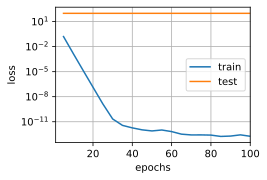

In [29]:
train(lambd=0)

### Training with Weight Decay

We traing with some weight decay, expecting that training and test error will decrease over time.

l2 norm of w:  0.049135815


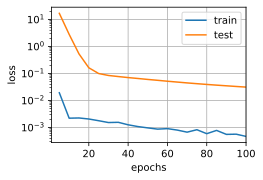

In [30]:
train(lambd=3)

## Concise Implementation using Gluon API

Gluon API supports passing **'wd'** parameter to the training to update parameter using weight decay. It also supports seperating parameters for each update. By default, Gluon decays both weights and biases simultaneously. Note that we can have **different optimizers for different sets of parameters**.

In [35]:
def train_gluon(wd):
    net = nn.Sequential()
    net.add(nn.Dense(1, use_bias=True))
    net.initialize(init.Normal(sigma=1))
    loss = gluon.loss.L2Loss()
    num_epochs, lr = 100, 0.003
    
    trainer_w = gluon.Trainer(net.collect_params('.*weight'), 'sgd', 
                              {'learning_rate': lr, 'wd': wd})
    trainer_b = gluon.Trainer(net.collect_params('.*bias'), 'sgd', 
                              {'learning_rate': lr})
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], legend=['train', 'test'])
    
    for epoch in range(1, num_epochs + 1):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer_w.step(batch_size)
            trainer_b.step(batch_size)
        if epoch % 5 == 0:
            animator.add(epoch, (evaluate_loss(net, train_iter, loss),
                                 evaluate_loss(net, test_iter, loss)))
    print('l2 norm of w: ', net[0].weight.data().norm().asscalar())

l2 norm of w:  12.825669


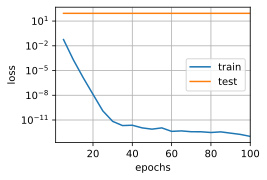

In [36]:
train_gluon(0)

l2 norm of w:  0.051045742


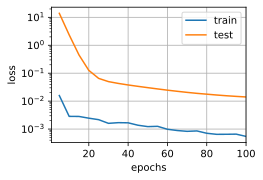

In [37]:
train_gluon(3)

## Accuracy of various values for hyperparameters

In [42]:
def train_hyper(wds):
    animator = d2l.Animator(xlabel='Weight Decay', ylabel='loss', yscale='log',
                                xlim=[0, 5], legend=['train', 'test'])
    for wd in wds:
        net = nn.Sequential()
        net.add(nn.Dense(1, use_bias=True))
        net.initialize(init.Normal(sigma=1))
        loss = gluon.loss.L2Loss()
        num_epochs, lr = 100, 0.003
    
        trainer_w = gluon.Trainer(net.collect_params('.*weight'), 'sgd', 
                                  {'learning_rate': lr, 'wd': wd})
        trainer_b = gluon.Trainer(net.collect_params('.*bias'), 'sgd', 
                                  {'learning_rate': lr})
        
        for epoch in range(1, num_epochs + 1):
            for X, y in train_iter:
                with autograd.record():
                    l = loss(net(X), y)
                l.backward()
                trainer_w.step(batch_size)
                trainer_b.step(batch_size)
        
        animator.add(wd, (evaluate_loss(net, train_iter, loss),
                          evaluate_loss(net, test_iter, loss)))

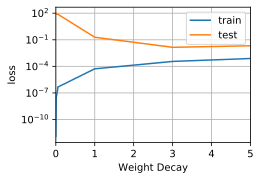

In [43]:
train_hyper([0, 0.01, 0.05, 0.05, 1, 3, 5, 10])

## Dropout

Neural Network are so flexible because they are not confined to looking at each feature individually. Instead, they can learn interactions among groups of features. In this case, even a small number of features will lead to neural network model overfitting data. Neural network learning algorithm therefore need to be modified to not fall into this kind of overfitting.

Neural network trainers use an idea of **dropout**, which means throughout training, on each iteration, dropout regularization consists of simply of zeroing out some fraction of the node in each layer before calculating subsequent layer (typically 50%).

Bishop also discovered the similar idea is that: training with noise is equivalent to Tikhonov regularization. For each training iteration, just add noise sampled from a distribution with mean zero $\epsilon \sim \mathcal{N}(0, \sigma^2)$ to the input $x$, yeilding a perturbed point $x' = x + \epsilon$. In expectation, $\mathbb{E}[x'] = x$.

In case of dropout regularization, dropout with drop probability $p$ is applied as follows:

$$ 
h' = \begin{cases}
  0 & \text{ with probability p} \\
  \frac{h}{1-p} & \text{otherwise}
\end{cases}
$$

### Dropout implementation

Gluon supports Dropout by just adding a new Dropout layer after each fully connected layer with a probability of dropout as parameter **nn.Dropout(prob)**

Fashion Minist with Dropout could be implemented as follows:

#### Implementation from Scratch

In [44]:
def dropout(X, drop_prob):
    assert 0 <= drop_prob <= 1
    if drop_prob == 1:
        return X.zeros_like()
    mask = nd.random.uniform(0, 1, X.shape) > drop_prob
    return mask * X / (1.0 - drop_prob)

In [49]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

W1 = nd.random.normal(scale=0.01, shape=(num_inputs, num_hiddens1))
b1 = nd.zeros(num_hiddens1)
W2 = nd.random.normal(scale=0.01, shape=(num_hiddens1, num_hiddens2))
b2 = nd.zeros(num_hiddens2)
W3 = nd.random.normal(scale=0.01, shape=(num_hiddens2, num_outputs))
b3 = nd.zeros(num_outputs)

params = [W1, b1, W2, b2, W3, b3]
for param in params:
    param.attach_grad()

drop_p1, drop_p2 = 0.2, 0.5

def net(X):
    X = X.reshape((-1, num_inputs))
    H1 = (nd.dot(X, W1) + b1).relu()
    if autograd.is_training():
        H1 = dropout(H1, drop_p1)
    H2 = (nd.dot(H1, W2) + b2).relu()
    if autograd.is_training():
        H2 = dropout(H2, drop_p2)
    return nd.dot(H2, W3) + b3

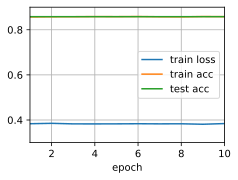

In [55]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = gluon.loss.SoftmaxCrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs,
              lambda batch_size: d2l.sgd(params, lr, batch_size))

#### Implementation using nn.Dropout()

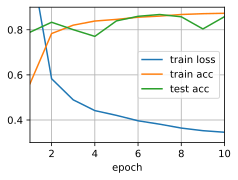

In [54]:
net = nn.Sequential()
net.add(nn.Dense(256, activation='relu'), 
        nn.Dropout(drop_p1),
        nn.Dense(256, activation='relu'),
        nn.Dropout(drop_p2),
        nn.Dense(10))
net.initialize(init.Normal(sigma=0.01))
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.5})
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)